In [39]:


# path =r'C:\Users\bartama\Desktop\PoliMi Stuff\NLP Stuff\Project'
# path = path+"\\tiny.jsonl"
# import pickle
# import gzip
# data_list = []

# # Read the JSONL file
# with open(path, 'r') as file:
#     for line in file:
#         json_obj = json.loads(line)
#         data_list.append(json_obj)
# output_path = "data_list.pkl.gz"
# with gzip.open(output_path, 'wb') as f:
#     pickle.dump(data_list, f)
    


In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer, pipeline
from huggingface_hub import hf_hub_download
import pandas as pd

**Datasets:**
- https://huggingface.co/datasets/yahma/alpaca-cleaned
- https://huggingface.co/datasets/ccdv/arxiv-summarization
- https://huggingface.co/datasets/HuggingFaceH4/no_robots
- https://huggingface.co/datasets/Open-Orca/SlimOrca?row=0

**You can also look**: https://huggingface.co/datasets?task_categories=task_categories:text-generation&sort=trending 

**Codes:**
- https://colab.research.google.com/drive/1kEV6i96AQ94xTCvSd11TxkEaksTb5o3U?usp=sharing#scrollTo=Dg9DRDL0jv7e
- https://huggingface.co/Intel/neural-chat-7b-v3-1


**Models:**
- Gemma 7b
- Mistral 7b
- Llama-2 7b
- TinyLlama
- DPO - Zephyr

## Reading things in

In [41]:
## This is for all of you

#from datasets import load_dataset

#dataset = load_dataset("Open-Orca/SlimOrca")

In [42]:
#path =r'C:\Users\bartama\Desktop\PoliMi Stuff\NLP Stuff\Project\\tiny.json'
import pandas as pd
import pickle
import gzip
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# Path to the compressed pickle file
input_path = "data_list.pkl.gz"

# Read the compressed pickle file
with gzip.open(input_path, 'rb') as f:
    data_list = pickle.load(f)


## Basic Overview

In [46]:
mystring = f"We have {len(data_list)} prompts in our dataset"
print(mystring)

We have 517982 prompts in our dataset


In [83]:
# Extract 'conversations' fields
conversations_list = [item.get('conversations', []) for item in data_list]

# Check if there are any non-conversation items
non_conversation_items = [item for item in conversations_list if not isinstance(item, list)]
print(f"We have {len(non_conversation_items)} non_conversation_items in our dataset" )

We have 0 non_conversation_items in our dataset


In [85]:
conversations_dict = {idx: conv for idx, conv in enumerate(conversations_list)}

In [56]:
# Extracting conversations
conversations_list = [item['conversations'] for item in data_list]
# Creating a dictionary of conversations with IDs
conversations_dict = {idx: conv for idx, conv in enumerate(conversations_list)}

In [90]:
flattened_data = []
for conv_id, conv in enumerate(conversations_list):
    for msg in conv:
        flattened_data.append({
            'conv_id': conv_id,
            'msg': msg['value'],
            'from': msg['from'],
            'weight': msg.get('weight'),
            'message_length': len(msg['value'].split())  # Assuming 'value' holds the message text
        })

In [104]:
df = pd.DataFrame(flattened_data)

In [105]:
# Calculate summary statistics
messages_per_conversation = df.groupby('conv_id').size().rename('message_count')
average_message_length = df.groupby('conv_id')['message_length'].mean().rename('average_message_length')

# Merge these statistics back into the original DataFrame
df = df.join(messages_per_conversation, on='conv_id')
df = df.join(average_message_length, on='conv_id')


In [102]:
# Calculate summary statistics
messages_per_conversation = df.groupby('conv_id').size().rename('message_count')
average_message_length = df.groupby('conv_id')['message_length'].mean().rename('average_message_length')

# Merge these statistics back into the original DataFrame
df = df.join(messages_per_conversation, on='conv_id')
df = df.join(average_message_length, on='conv_id')

In [106]:
df

,conv_id,msg,from,weight,message_length,message_count,average_message_length
0,0,You are an AI assistant. You will be given a t...,system,NaN,19,3,214.333333
1,0,"Write an article based on this ""A man has been...",human,0.0,36,3,214.333333
2,0,Title: Tragedy Strikes in Sydney: Victims Stab...,gpt,1.0,588,3,214.333333
3,1,You are an AI assistant that follows instructi...,system,NaN,16,3,43.333333
4,1,Answer the following question: - number is 54 ...,human,0.0,101,3,43.333333
...,...,...,...,...,...,...,...
1520024,517980,"Can we conclude from ""A man with black hair wh...",human,0.0,51,3,54.000000
1520025,517980,"It is not possible to tell.\n\nThe statement ""...",gpt,1.0,76,3,54.000000
1520026,517981,You are an AI assistant that helps people find...,system,NaN,35,3,65.333333
1520027,517981,"Question. Given the sentence ""A man in pink t-...",human,0.0,34,3,65.333333


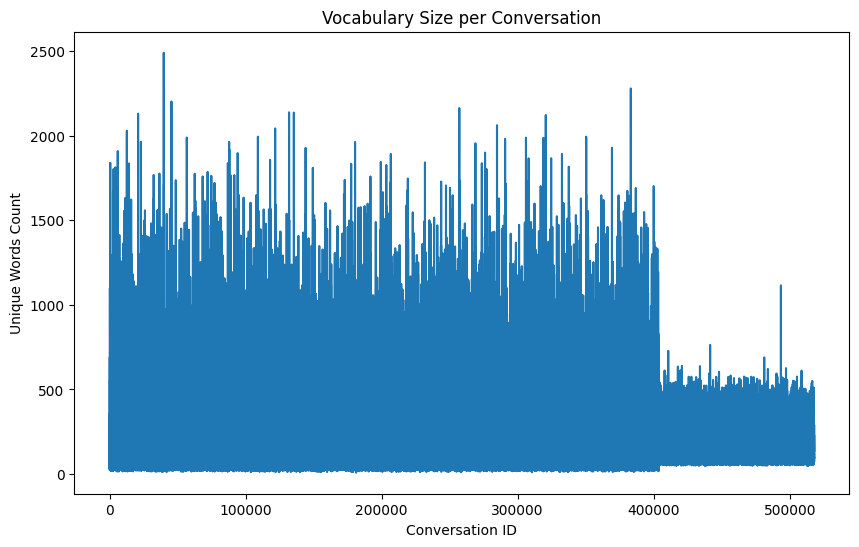

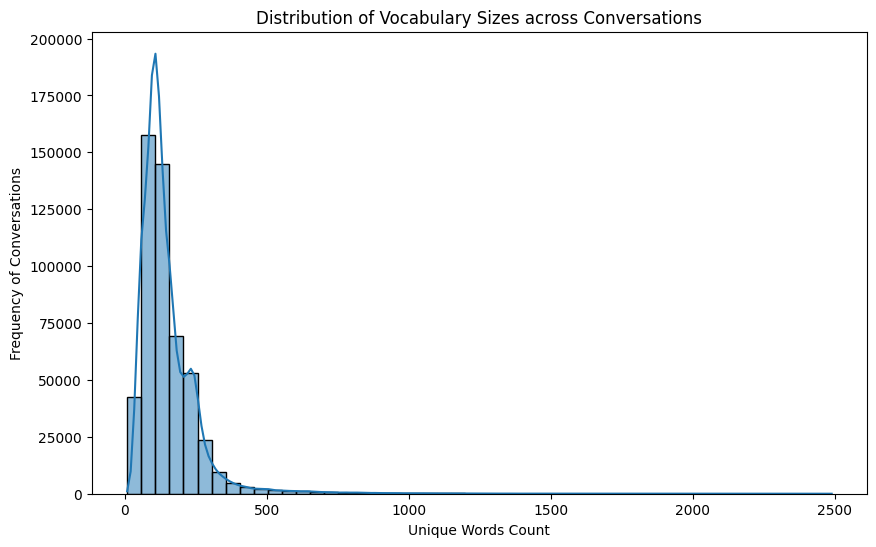

In [109]:


# Tokenize the messages and count unique words per conversation
df['tokens'] = df['msg'].str.lower().str.split()  # Tokenize and convert to lowercase to ensure uniqueness
vocab_per_conv = df.groupby('conv_id')['tokens'].sum().apply(lambda tokens: len(set(tokens)))

# Plot the vocabulary size per conversation
plt.figure(figsize=(10, 6))
plt.plot(vocab_per_conv.values)
plt.title('Vocabulary Size per Conversation')
plt.xlabel('Conversation ID')
plt.ylabel('Unique Words Count')
plt.show()

# Since plotting all conversation IDs can be dense, let's also plot a histogram of vocabulary sizes
plt.figure(figsize=(10, 6))
sns.histplot(vocab_per_conv.values, bins=50, kde=True)
plt.title('Distribution of Vocabulary Sizes across Conversations')
plt.xlabel('Unique Words Count')
plt.ylabel('Frequency of Conversations')
plt.show()


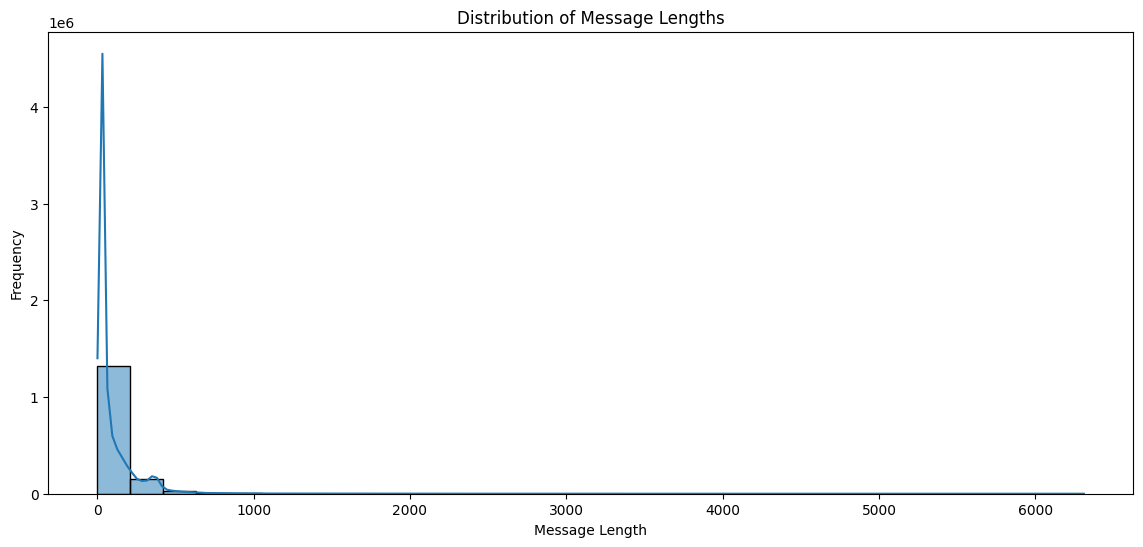

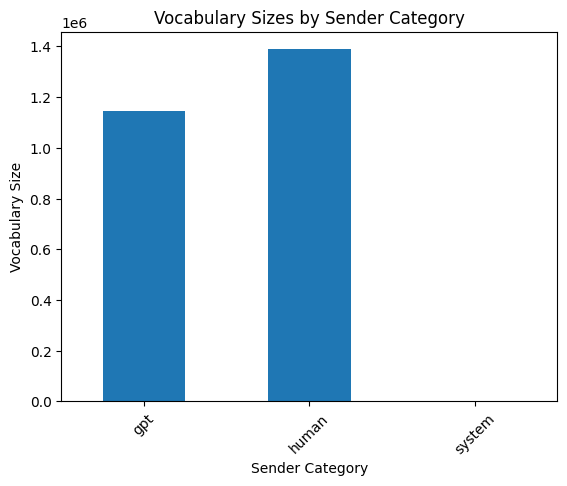

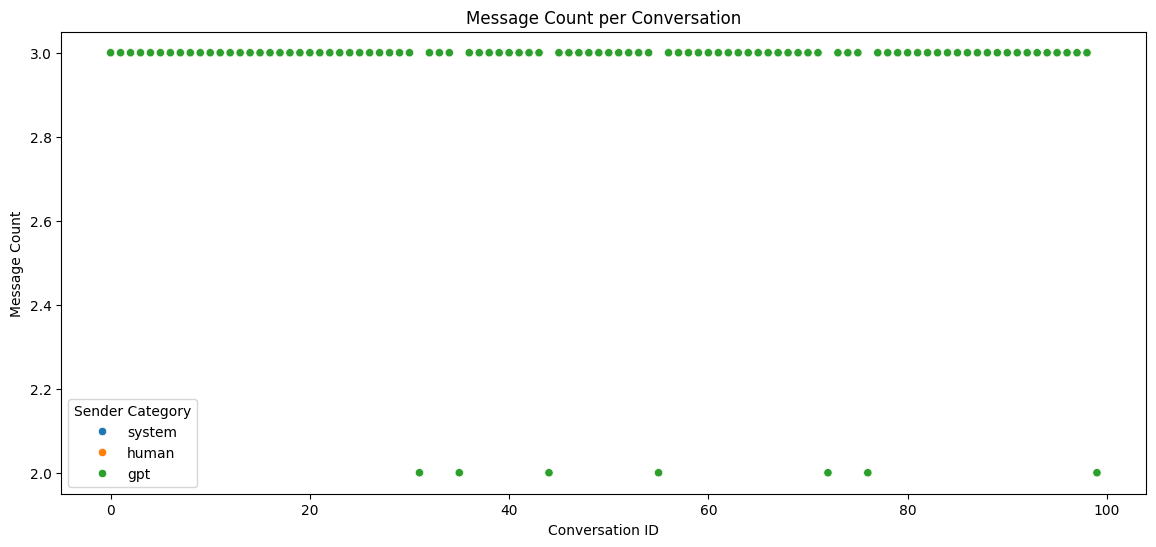

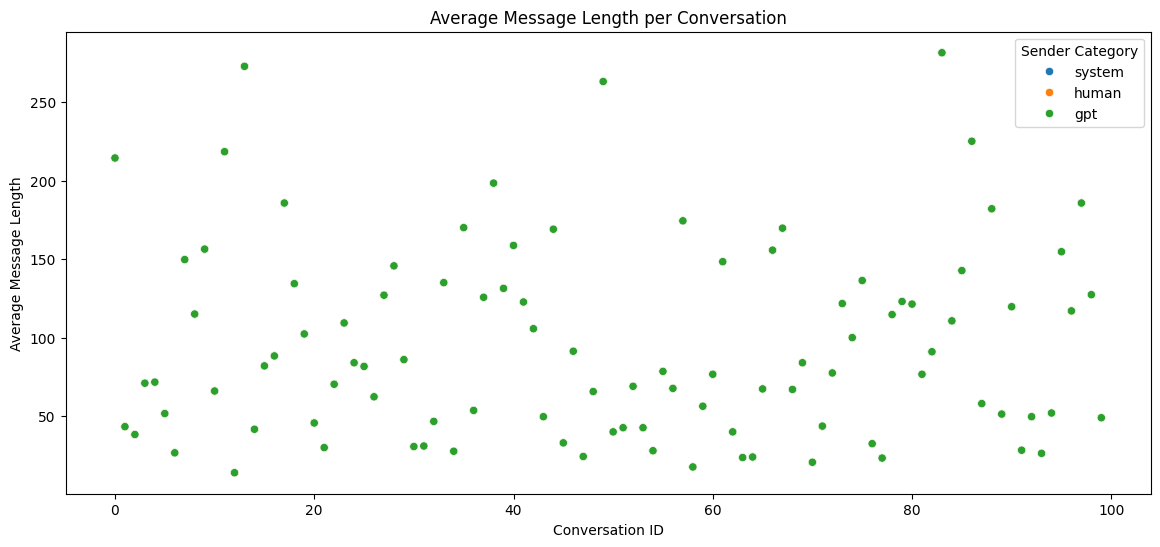

In [110]:


# Assuming 'df' is your DataFrame and is already loaded with the data you provided.

# Vocabulary Size Analysis
# Concatenate all messages and split into words to calculate overall vocabulary size
all_words = ' '.join(df['msg']).split()
vocab_size = len(set(all_words))

# Vocabulary size by `from` category
vocab_sizes_by_from = df.groupby('from')['msg'].apply(lambda x: len(set(' '.join(x).split())))

# Plotting Message Length Distribution
plt.figure(figsize=(14, 6))
sns.histplot(df['message_length'], bins=30, kde=True)
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

# Plotting Vocabulary Sizes by `from` Category
vocab_sizes_by_from.plot(kind='bar')
plt.title('Vocabulary Sizes by Sender Category')
plt.xlabel('Sender Category')
plt.ylabel('Vocabulary Size')
plt.xticks(rotation=45)
plt.show()

# Plotting Message Count and Average Message Length per Conversation
# Selecting a subset of conversations for clearer visualization
subset_df = df[df['conv_id'] < 100]

plt.figure(figsize=(14, 6))
sns.scatterplot(data=subset_df, x='conv_id', y='message_count', hue='from')
plt.title('Message Count per Conversation')
plt.xlabel('Conversation ID')
plt.ylabel('Message Count')
plt.legend(title='Sender Category')
plt.show()

plt.figure(figsize=(14, 6))
sns.scatterplot(data=subset_df, x='conv_id', y='average_message_length', hue='from')
plt.title('Average Message Length per Conversation')
plt.xlabel('Conversation ID')
plt.ylabel('Average Message Length')
plt.legend(title='Sender Category')
plt.show()